In [1]:
import os
import sys

import pandas as pd
import numpy as np
import geopandas as gpd
import folium

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_25266/4027295472.py:6: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


2024-01-19 13:52:12 Configured OSMnx 1.1.2
2024-01-19 13:52:12 HTTP response caching is on


## Read top 10 cities

In [2]:
top_10 = pd.read_csv('../../../data/processed/nearshoring/top_10_cities_analysis.csv')

In [3]:
top_10.loc[1,"city"]

'Guadalajara'

## Test comparison process

### Download data for specific city

Hexagons

In [4]:
schema = 'hexgrid'
table = 'hexgrid_8_city_2020'
query = f"SELECT * FROM {schema}.{table} WHERE \"city\" = \'{top_10.loc[0,'city']}\'"
hex_polygon = aup.gdf_from_query(query)

In [5]:
gdf = hex_polygon.to_crs("EPSG:6372")
gdf = gdf.buffer(1).reset_index().rename(columns={0: "geometry"})
gdf = gdf.set_geometry("geometry")
gdf = gdf.to_crs("EPSG:4326")
poly_wkt = gdf.dissolve().geometry.to_wkt()[0]

2010 census data

In [6]:
schema = 'censo'
table = 'censo_mza_centroid_2010'
query = f"SELECT * FROM {schema}.{table} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
censo_10 = aup.gdf_from_query(query, geometry_col="geometry")
print(censo_10.shape)
censo_10.head(4)

(63358, 193)


,cvegeo,geometry,pobtot,pobmas,pobfem,p_0a2,p_0a2_m,p_0a2_f,p_3ymas,p_3ymas_m,...,vph_radio,vph_tv,vph_refri,vph_lavad,vph_autom,vph_pc,vph_telef,vph_cel,vph_inter,metropolis
0,0900200011057004,POINT (-99.16472 19.46530),22,11,11,0,0,0,19,9,...,6,6,6,6,5,4,5,6,4,ZMVM
1,0900200010542047,POINT (-99.16213 19.47062),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ZMVM
2,0900200010542048,POINT (-99.16225 19.47082),17,10,7,0,0,0,17,10,...,6,7,5,5,3,5,0,5,0,ZMVM
3,0900200010542050,POINT (-99.16251 19.47114),4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ZMVM


2020 census data

In [7]:
table = 'censo_mza_centroid_2020'
query = f"SELECT * FROM {schema}.{table} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
censo_20 = aup.gdf_from_query(query, geometry_col="geometry")
print(censo_20.shape)
censo_20.head(4)

(66559, 225)


,cvegeo,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,p_3ymas_f,...,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic,metropolis
0,0900500010309001,POINT (-99.14573 19.52433),3,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,ZMVM
1,0900200011042049,POINT (-99.20754 19.47537),9,5,4,None,None,None,7,4,...,None,None,None,0,0,0,None,None,0,ZMVM
2,0900200011042048,POINT (-99.20757 19.47528),11,6,5,None,0,None,10,6,...,3,None,0,0,None,0,0,None,0,ZMVM
3,0900500013445037,POINT (-99.12610 19.57468),24,14,10,0,0,0,24,14,...,5,5,None,None,None,0,0,None,0,ZMVM


### Merge 2010 and 2020 census data

Filter used columns

In [8]:
censo_20 = censo_20[['pobtot','vivtot','geometry']]
censo_20 = censo_20.rename(columns={'pobtot':'20_pobtot',
                                   'vivtot':'20_vivtot'})
censo_10 = censo_10[['pobtot','vivtot','geometry']]
censo_10 = censo_10.rename(columns={'pobtot':'10_pobtot',
                                   'vivtot':'10_vivtot'})

2020 spatial intersection

In [9]:
censo_hex = censo_20.overlay(hex_polygon, how='intersection')
censo_hex = censo_hex.groupby('hex_id_8').sum(numeric_only=True)
censo_hex = censo_hex.reset_index()
hex_pob = hex_polygon.merge(censo_hex, on='hex_id_8', how='left')

2010 spatial intersection

In [10]:
censo_hex = censo_10.overlay(hex_polygon, how='intersection')
censo_hex = censo_hex.groupby('hex_id_8').sum(numeric_only=True)
censo_hex = censo_hex.reset_index()
hex_pob = hex_pob.merge(censo_hex, on='hex_id_8', how='left')

In [11]:
hex_pob

,hex_id_8,geometry,CVEGEO,NOMGEO,city,type,20_pobtot,20_vivtot,10_pobtot,10_vivtot
0,884995b889fffff,"POLYGON ((-99.18300 19.49493, -99.17848 19.497...",09002,Azcapotzalco,CDMX,urban,9150.0,3004.0,11473.0,3515.0
1,884995b8d1fffff,"POLYGON ((-99.20183 19.49350, -99.19730 19.496...",09002,Azcapotzalco,CDMX,urban,12761.0,4018.0,12034.0,3661.0
2,884995b8e1fffff,"POLYGON ((-99.15894 19.48898, -99.15441 19.491...",09002,Azcapotzalco,CDMX,urban,12.0,2.0,178.0,50.0
3,884995b81bfffff,"POLYGON ((-99.17143 19.46475, -99.16690 19.467...",09002,Azcapotzalco,CDMX,urban,10234.0,4317.0,11747.0,4349.0
4,884995b8c9fffff,"POLYGON ((-99.18608 19.47140, -99.18156 19.474...",09002,Azcapotzalco,CDMX,urban,14614.0,5614.0,14470.0,5161.0
...,...,...,...,...,...,...,...,...,...,...
1762,8849958c91fffff,"POLYGON ((-99.05952 19.41885, -99.05499 19.421...",09017,Venustiano Carranza,CDMX,urban,18579.0,5954.0,20312.0,6204.0
1763,884995b959fffff,"POLYGON ((-99.10343 19.43883, -99.09891 19.441...",09017,Venustiano Carranza,CDMX,urban,17121.0,5529.0,15566.0,4878.0
1764,884995b94dfffff,"POLYGON ((-99.07415 19.42551, -99.06963 19.428...",09017,Venustiano Carranza,CDMX,urban,1670.0,465.0,1681.0,510.0
1765,884995bb33fffff,"POLYGON ((-99.10760 19.43076, -99.10307 19.433...",09017,Venustiano Carranza,CDMX,urban,12975.0,4382.0,12001.0,3753.0


### New urbanizations

In [14]:
hex_pob = hex_pob.loc[(hex_pob['20_vivtot']>=0)|(hex_pob['20_pobtot']>=0)|
(hex_pob['10_vivtot']>=0)|(hex_pob['10_pobtot']>=0)].copy()
hex_pob = hex_pob.fillna(0)

In [15]:
hex_pob['nueva_urbanizacion'] = 0
hex_pob.loc[(hex_pob['20_vivtot']>0)&(hex_pob['10_vivtot']==0),'nueva_urbanizacion'] = 1

<AxesSubplot: >

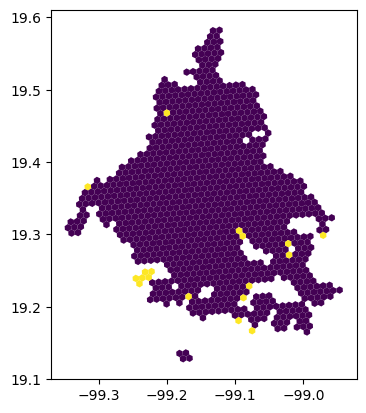

In [16]:
hex_pob.plot('nueva_urbanizacion')

In [18]:
hex_pob['20_vivtot'].sum()

3028849.0

### Summary data

In [21]:
city_name = hex_pob.city.unique()[0]
viv10 = hex_pob['10_vivtot'].sum()
viv20 = hex_pob['20_vivtot'].sum()
pob10 = hex_pob['10_pobtot'].sum()
pob20 = hex_pob['20_pobtot'].sum()
chng_viv = viv20 - viv10
pct_chng_viv = chng_viv / viv10
chng_pob = pob20 - pob10
pct_chng_pob = chng_pob / pob10
nueva_urb_viv = hex_pob.loc[hex_pob.nueva_urbanizacion==1,'20_vivtot'].sum()
pct_nueva_urb_viv = nueva_urb_viv / chng_viv
nueva_urb_pob = hex_pob.loc[hex_pob.nueva_urbanizacion==1,'20_pobtot'].sum()
pct_nueva_urb_pob = nueva_urb_pob / chng_pob
city_data = [city_name, viv10, viv20, pob10, pob20, chng_viv,
            pct_chng_viv, chng_pob, pct_chng_pob, nueva_urb_viv,
            pct_nueva_urb_viv, nueva_urb_pob, pct_nueva_urb_pob]

In [22]:
df = pd.DataFrame(columns=['ciudad','viv_10','viv_20','pob_10','pob_20',
                           'cambio_viv','pct_cambio_viv','cambio_pob',
                           'pct_cambio_pob','nueva_urbanizacion_viv',
                           'pct_nueva_urbanizacion_viv',
                           'nueva_urbanizacion_pob',
                          'pct_nueva_urbanizacion_pob'])

In [23]:
df.loc[0,df.columns] = city_data

In [24]:
df

,ciudad,viv_10,viv_20,pob_10,pob_20,cambio_viv,pct_cambio_viv,cambio_pob,pct_cambio_pob,nueva_urbanizacion_viv,pct_nueva_urbanizacion_viv,nueva_urbanizacion_pob,pct_nueva_urbanizacion_pob
0,CDMX,2743040.0,3028849.0,8851904.0,9189973.0,285809.0,0.104194,338069.0,0.038192,3220.0,0.011266,9669.0,0.028601


## Process pipeline

In [4]:
from tqdm import tqdm

In [5]:
gdf_city_sprawl = gpd.GeoDataFrame()
df_summary = pd.DataFrame(columns=['ciudad','viv_10','viv_20','pob_10','pob_20',
                           'cambio_viv','pct_cambio_viv','cambio_pob',
                           'pct_cambio_pob','nueva_urbanizacion_viv',
                           'pct_nueva_urbanizacion_viv',
                           'nueva_urbanizacion_pob',
                          'pct_nueva_urbanizacion_pob'])

for i in tqdm(range(len(top_10)), position=0, leave=True):
    
    city = top_10.loc[i,"city"]

    schema = 'hexgrid'
    table = 'hexgrid_8_city_2020'
    query = f"SELECT * FROM {schema}.{table} WHERE \"city\" = \'{city}\'"
    hex_polygon = aup.gdf_from_query(query)

    gdf = hex_polygon.to_crs("EPSG:6372")
    gdf = gdf.buffer(1).reset_index().rename(columns={0: "geometry"})
    gdf = gdf.set_geometry("geometry")
    gdf = gdf.to_crs("EPSG:4326")
    poly_wkt = gdf.dissolve().geometry.to_wkt()[0]

    schema = 'censo'
    table = 'censo_mza_centroid_2010'
    query = f"SELECT * FROM {schema}.{table} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
    censo_10 = aup.gdf_from_query(query, geometry_col="geometry")

    table = 'censo_mza_centroid_2020'
    query = f"SELECT * FROM {schema}.{table} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
    censo_20 = aup.gdf_from_query(query, geometry_col="geometry")

    censo_20 = censo_20[['pobtot','vivtot','geometry']]
    censo_20 = censo_20.rename(columns={'pobtot':'20_pobtot',
                                       'vivtot':'20_vivtot'})
    censo_10 = censo_10[['pobtot','vivtot','geometry']]
    censo_10 = censo_10.rename(columns={'pobtot':'10_pobtot',
                                       'vivtot':'10_vivtot'})

    censo_hex = censo_20.overlay(hex_polygon, how='intersection')
    censo_hex = censo_hex.groupby('hex_id_8').sum(numeric_only=True)
    censo_hex = censo_hex.reset_index()
    hex_pob = hex_polygon.merge(censo_hex, on='hex_id_8', how='left')

    censo_hex = censo_10.overlay(hex_polygon, how='intersection')
    censo_hex = censo_hex.groupby('hex_id_8').sum(numeric_only=True)
    censo_hex = censo_hex.reset_index()
    hex_pob = hex_pob.merge(censo_hex, on='hex_id_8', how='left')

    hex_pob = hex_pob.loc[(hex_pob['20_vivtot']>=0)|(hex_pob['20_pobtot']>=0)|(hex_pob['10_vivtot']>=0)|(hex_pob['10_pobtot']>=0)].copy()
    hex_pob = hex_pob.fillna(0)

    hex_pob['nueva_urbanizacion'] = 0
    hex_pob.loc[(hex_pob['20_vivtot']>0)&(hex_pob['10_vivtot']==0),'nueva_urbanizacion'] = 1

    city_name = hex_pob.city.unique()[0]
    viv10 = hex_pob['10_vivtot'].sum()
    viv20 = hex_pob['20_vivtot'].sum()
    pob10 = hex_pob['10_pobtot'].sum()
    pob20 = hex_pob['20_pobtot'].sum()
    chng_viv = viv20 - viv10
    pct_chng_viv = chng_viv / viv10
    chng_pob = pob20 - pob10
    pct_chng_pob = chng_pob / pob10
    nueva_urb_viv = hex_pob.loc[hex_pob.nueva_urbanizacion==1,'20_vivtot'].sum()
    pct_nueva_urb_viv = nueva_urb_viv / chng_viv
    nueva_urb_pob = hex_pob.loc[hex_pob.nueva_urbanizacion==1,'20_pobtot'].sum()
    pct_nueva_urb_pob = nueva_urb_pob / chng_pob
    city_data = [city_name, viv10, viv20, pob10, pob20, chng_viv,
                pct_chng_viv, chng_pob, pct_chng_pob, nueva_urb_viv,
                pct_nueva_urb_viv, nueva_urb_pob, pct_nueva_urb_pob]

    df_summary.loc[i,df_summary.columns] = city_data

    gdf_city_sprawl = pd.concat([gdf_city_sprawl, hex_pob],
            ignore_index = True, axis = 0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [08:59<00:00, 49.04s/it]


In [6]:
df_summary

,ciudad,viv_10,viv_20,pob_10,pob_20,cambio_viv,pct_cambio_viv,cambio_pob,pct_cambio_pob,nueva_urbanizacion_viv,pct_nueva_urbanizacion_viv,nueva_urbanizacion_pob,pct_nueva_urbanizacion_pob
0,CDMX,2743040.0,3028849.0,8851904.0,9189973.0,285809.0,0.104194,338069.0,0.038192,3220.0,0.011266,9669.0,0.028601
1,Guadalajara,1289251.0,1688284.0,4296874.0,5011955.0,399033.0,0.309508,715081.0,0.166419,118885.0,0.297933,267447.0,0.374009
2,ZMVM,3299149.0,3944590.0,10886967.0,12203666.0,645441.0,0.195639,1316699.0,0.120943,132382.0,0.205103,252305.0,0.191619
3,Monterrey,1307811.0,1781446.0,4131710.0,5245066.0,473635.0,0.362159,1113356.0,0.269466,234051.0,0.494159,561810.0,0.504609
4,Tijuana,557320.0,659477.0,1589154.0,1995007.0,102157.0,0.1833,405853.0,0.255389,51621.0,0.50531,145782.0,0.359199
5,Queretaro,294594.0,486148.0,920993.0,1379212.0,191554.0,0.65023,458219.0,0.497527,88230.0,0.460601,196644.0,0.429149
6,Puebla,710095.0,860104.0,2276528.0,2631320.0,150009.0,0.211252,354792.0,0.155848,9124.0,0.060823,20175.0,0.056864
7,Juarez,484017.0,515318.0,1318616.0,1500597.0,31301.0,0.064669,181981.0,0.138009,6310.0,0.201591,18240.0,0.10023
8,Toluca,457394.0,613883.0,1599283.0,1972655.0,156489.0,0.342132,373372.0,0.233462,47613.0,0.304258,119645.0,0.320444
9,Saltillo,245515.0,307240.0,784671.0,996503.0,61725.0,0.25141,211832.0,0.269963,7549.0,0.122301,21461.0,0.101311


In [7]:
df_summary.to_csv('../../../data/processed/nearshoring/urban_growth.csv')

In [8]:
gdf_city_sprawl.to_file('../../../data/processed/nearshoring/urban_growth.geojson')